In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import gc  # Garbage collector for memory management

In [2]:
AIRPORT_CODES_FILE = '/kaggle/input/airlines/Airport_Codes.csv'
FLIGHTS_FILE = '/kaggle/input/airlines/Flights.csv'
TICKETS_FILE = '/kaggle/input/airlines/Tickets.csv'

In [3]:
airport_codes = pd.read_csv(AIRPORT_CODES_FILE)

In [4]:
def create_route(origin, destination):
    return '-'.join(sorted([origin, destination]))

In [10]:
def calculate_cost(row, airport_costs):
    distance = row['DISTANCE']
    origin = row['ORIGIN']
    destination = row['DESTINATION']
    
    fuel_maintenance_crew = 8 * distance
    depreciation_insurance_other = 1.18 * distance
    total_variable_cost = fuel_maintenance_crew + depreciation_insurance_other
    
    origin_cost = airport_costs.get(origin, 5000)  # Default to medium airport cost
    destination_cost = airport_costs.get(destination, 5000)
    total_airport_cost = origin_cost + destination_cost
    
    dep_delay = row['DEP_DELAY']
    arr_delay = row['ARR_DELAY']
    
    dep_delay_cost = ((dep_delay - 15) * 75) if dep_delay > 15 else 0
    arr_delay_cost = ((arr_delay - 15) * 75) if arr_delay > 15 else 0
    
    total_delay_cost = dep_delay_cost + arr_delay_cost
    
    total_cost = total_variable_cost + total_airport_cost + total_delay_cost
    return total_cost


In [11]:
def calculate_revenue(row):
    passengers = row['PASSENGERS']
    itin_fare = row['ITIN_FARE']
    
    revenue_fares = passengers * itin_fare
    
    baggage_fee = 70 * passengers * 0.5
    
    total_revenue = revenue_fares + baggage_fee
    return total_revenue


In [12]:
airport_costs = {}
for _, row in airport_codes.iterrows():
    airport_code = row['IATA_CODE']
    size = row['TYPE'].lower()
    if size == 'medium_airport':
        airport_costs[airport_code] = 5000
    elif size == 'large_airport':
        airport_costs[airport_code] = 10000
    else:
        airport_costs[airport_code] = 5000 

In [13]:
busiest_routes_counter = Counter()

# Define chunk size
CHUNK_SIZE = 100000

for chunk in pd.read_csv(TICKETS_FILE, chunksize=CHUNK_SIZE):
    if 'CANCELLED' in chunk.columns:
        chunk = chunk[chunk['CANCELLED'] == 0]
    
    if {'ORIGIN', 'DESTINATION'}.issubset(chunk.columns):
        chunk['ROUTE'] = chunk.apply(lambda row: create_route(row['ORIGIN'], row['DESTINATION']), axis=1)
        route_counts = chunk['ROUTE'].value_counts()
        busiest_routes_counter.update(route_counts.to_dict())
    
    del chunk
    gc.collect()

# Get the top 10 busiest routes
top_10_busiest = busiest_routes_counter.most_common(10)

print("Top 10 Busiest Round Trip Routes (1Q2019):")
for route, count in top_10_busiest:
    print(f"{route}: {count} round trip flights")


Top 10 Busiest Round Trip Routes (1Q2019):
JFK-LAX: 2801 round trip flights
LGA-ORD: 2354 round trip flights
JFK-SFO: 2181 round trip flights
LAX-SFO: 2078 round trip flights
LAX-ORD: 1955 round trip flights
EWR-SFO: 1885 round trip flights
LGA-MIA: 1817 round trip flights
LAX-SEA: 1809 round trip flights
BOS-SFO: 1735 round trip flights
ATL-LAX: 1722 round trip flights


In [14]:
print("\n### Task 2: Determining the 10 Most Profitable Round Trip Routes...")

ticket_passengers = defaultdict(int)
ticket_revenue = defaultdict(float)

# Define Chunk Size
CHUNK_SIZE = 500000 

for chunk in pd.read_csv(TICKETS_FILE, chunksize=CHUNK_SIZE):
    if 'CANCELLED' in chunk.columns:
        chunk = chunk[chunk['CANCELLED'] == 0]
    
    required_columns = {'ORIGIN', 'DESTINATION', 'PASSENGERS', 'ITIN_FARE'}
    if required_columns.issubset(chunk.columns):
        chunk['ITIN_FARE'] = pd.to_numeric(chunk['ITIN_FARE'], errors='coerce')
        chunk['PASSENGERS'] = pd.to_numeric(chunk['PASSENGERS'], errors='coerce')
        
        initial_rows = chunk.shape[0]
        chunk = chunk.dropna(subset=['ITIN_FARE', 'PASSENGERS'])
        final_rows = chunk.shape[0]
        dropped_rows = initial_rows - final_rows
        if dropped_rows > 0:
            print(f"Dropped {dropped_rows} rows due to invalid 'ITIN_FARE' or 'PASSENGERS'")
        
        chunk['ROUTE'] = chunk.apply(lambda row: create_route(row['ORIGIN'], row['DESTINATION']), axis=1)
        
        route_group = chunk.groupby('ROUTE').agg({
            'PASSENGERS': 'sum',
            'ITIN_FARE': 'mean'
        }).reset_index()
        
        for _, row_data in route_group.iterrows():
            route = row_data['ROUTE']
            passengers = row_data['PASSENGERS']
            avg_fare = row_data['ITIN_FARE']
            revenue = (avg_fare * passengers) + (70 * passengers * 0.5) 
            ticket_passengers[route] += passengers
            ticket_revenue[route] += revenue
    
    # Free memory
    del chunk
    gc.collect()

tickets_aggregated = pd.DataFrame({
    'ROUTE': list(ticket_passengers.keys()),
    'TOTAL_PASSENGERS': list(ticket_passengers.values()),
    'TOTAL_REVENUE': list(ticket_revenue.values())
})

print("\n### Aggregated Ticket Data Sample:")
display(tickets_aggregated.head())

flight_costs = defaultdict(float)
flight_counts = defaultdict(int)

for chunk in pd.read_csv(FLIGHTS_FILE, chunksize=CHUNK_SIZE):
    if 'CANCELLED' in chunk.columns:
        chunk = chunk[chunk['CANCELLED'] == 0]
    
    required_columns = {'ORIGIN', 'DESTINATION', 'DEP_DELAY', 'ARR_DELAY', 'DISTANCE'}
    if required_columns.issubset(chunk.columns):
        chunk['DEP_DELAY'] = pd.to_numeric(chunk['DEP_DELAY'], errors='coerce')
        chunk['ARR_DELAY'] = pd.to_numeric(chunk['ARR_DELAY'], errors='coerce')
        chunk['DISTANCE'] = pd.to_numeric(chunk['DISTANCE'], errors='coerce')
        
        initial_rows = chunk.shape[0]
        chunk = chunk.dropna(subset=['DEP_DELAY', 'ARR_DELAY', 'DISTANCE'])
        final_rows = chunk.shape[0]
        dropped_rows = initial_rows - final_rows
        if dropped_rows > 0:
            print(f"Dropped {dropped_rows} rows due to invalid 'DEP_DELAY', 'ARR_DELAY', or 'DISTANCE'")
        
        chunk['ROUTE'] = chunk.apply(lambda row: create_route(row['ORIGIN'], row['DESTINATION']), axis=1)
        
        chunk['COST'] = chunk.apply(lambda row: calculate_cost(row, airport_costs), axis=1)
        
        route_group = chunk.groupby('ROUTE').agg({
            'COST': 'sum',
            'ROUTE': 'count' 
        }).rename(columns={'ROUTE': 'FLIGHTS'}).reset_index()
        
        for _, row_data in route_group.iterrows():
            route = row_data['ROUTE']
            flight_costs[route] += row_data['COST']
            flight_counts[route] += row_data['FLIGHTS']
    
    # Free memory
    del chunk
    gc.collect()

flights_aggregated = pd.DataFrame({
    'ROUTE': list(flight_costs.keys()),
    'TOTAL_COST': list(flight_costs.values()),
    'FLIGHTS': list(flight_counts.values())
})

print("\n Aggregated Flights Data Sample:")
display(flights_aggregated.head())

merged_aggregated = pd.merge(tickets_aggregated, flights_aggregated, on='ROUTE', how='inner')

merged_aggregated['PROFIT'] = merged_aggregated['TOTAL_REVENUE'] - merged_aggregated['TOTAL_COST']

print("\n Merged Aggregated Data Sample:")
display(merged_aggregated.head())

top_10_profitable = merged_aggregated.sort_values(by='PROFIT', ascending=False).head(10)

# Display Top 10 Most Profitable Routes
print("\n Top 10 Most Profitable Round Trip Routes (1Q2019):")
display(top_10_profitable[['ROUTE', 'PROFIT', 'TOTAL_REVENUE', 'TOTAL_COST', 'FLIGHTS']])



### Task 2: Determining the 10 Most Profitable Round Trip Routes...
Dropped 1581 rows due to invalid 'ITIN_FARE' or 'PASSENGERS'
Dropped 1737 rows due to invalid 'ITIN_FARE' or 'PASSENGERS'
Dropped 2770 rows due to invalid 'ITIN_FARE' or 'PASSENGERS'

### Aggregated Ticket Data Sample:


,ROUTE,TOTAL_PASSENGERS,TOTAL_REVENUE
0,ABE-ABI,2.0,1586.0
1,ABE-ABQ,3.0,1695.0
2,ABE-ABY,2.0,892.0
3,ABE-AGS,3.0,1278.0
4,ABE-ALB,1.0,319.0


Dropped 830 rows due to invalid 'DEP_DELAY', 'ARR_DELAY', or 'DISTANCE'
Dropped 1385 rows due to invalid 'DEP_DELAY', 'ARR_DELAY', or 'DISTANCE'
Dropped 1175 rows due to invalid 'DEP_DELAY', 'ARR_DELAY', or 'DISTANCE'


/tmp/ipykernel_30/513351338.py:56: DtypeWarning: Columns (3,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(FLIGHTS_FILE, chunksize=CHUNK_SIZE):


Dropped 3657 rows due to invalid 'DEP_DELAY', 'ARR_DELAY', or 'DISTANCE'

 Aggregated Flights Data Sample:


,ROUTE,TOTAL_COST,FLIGHTS
0,ABE-ATL,9757136.04,434
1,ABE-CLT,10140371.16,502
2,ABE-DTW,10363194.00,496
3,ABE-FLL,1019905.20,40
4,ABE-ORD,8004057.96,318



 Merged Aggregated Data Sample:


,ROUTE,TOTAL_PASSENGERS,TOTAL_REVENUE,TOTAL_COST,FLIGHTS,PROFIT
0,ABE-ATL,127.0,70566.027739,9757136.04,434,-9.686570e+06
1,ABE-CLT,66.0,30807.988636,10140371.16,502,-1.010956e+07
2,ABE-DTW,106.0,48035.461538,10363194.00,496,-1.031516e+07
3,ABE-FLL,180.0,43607.750700,1019905.20,40,-9.762974e+05
4,ABE-ORD,54.0,27200.018182,8004057.96,318,-7.976858e+06



 Top 10 Most Profitable Round Trip Routes (1Q2019):


,ROUTE,PROFIT,TOTAL_REVENUE,TOTAL_COST,FLIGHTS
2820,PIT-SAN,53515.654883,132481.814883,78966.16,2
2557,MSP-PBI,44716.313171,111356.673171,66640.36,2
2266,LAX-MSN,23565.308743,94538.628743,70973.32,2
1792,GSP-MCO,2868.502871,99355.782871,96487.28,4
1651,FAT-ORD,-3012.663095,58750.136905,61762.80,2
2280,LAX-PSC,-3327.381739,42296.978261,45624.36,2
614,BTR-DCA,-4394.384810,43915.215190,48309.60,2
1753,GJT-LAX,-9407.400000,11605.500000,21012.90,1
2214,ORD-TWF,-9770.835604,19495.604396,29266.44,1
2835,PSP-SJC,-14047.200000,4983.000000,19030.20,1


In [17]:
# Recommend top 5 profitable routes
recommended_routes = top_10_profitable.head(5).copy()

print("Recommended 5 Round Trip Routes:")
display(recommended_routes[['ROUTE', 'PROFIT', 'TOTAL_REVENUE', 'TOTAL_COST', 'FLIGHTS']])


Recommended 5 Round Trip Routes:


,ROUTE,PROFIT,TOTAL_REVENUE,TOTAL_COST,FLIGHTS
2820,PIT-SAN,53515.654883,132481.814883,78966.16,2
2557,MSP-PBI,44716.313171,111356.673171,66640.36,2
2266,LAX-MSN,23565.308743,94538.628743,70973.32,2
1792,GSP-MCO,2868.502871,99355.782871,96487.28,4
1651,FAT-ORD,-3012.663095,58750.136905,61762.80,2


In [18]:
# Define upfront cost
UPFRONT_COST = 90000000  # $90 million

recommended_routes['BREAKEVEN_FLIGHTS'] = recommended_routes['PROFIT'].apply(lambda x: UPFRONT_COST / x if x > 0 else np.nan)

print("Breakeven Analysis for Recommended Routes:")
display(recommended_routes[['ROUTE', 'BREAKEVEN_FLIGHTS', 'PROFIT', 'TOTAL_REVENUE', 'TOTAL_COST', 'FLIGHTS']])


Breakeven Analysis for Recommended Routes:


,ROUTE,BREAKEVEN_FLIGHTS,PROFIT,TOTAL_REVENUE,TOTAL_COST,FLIGHTS
2820,PIT-SAN,1681.750886,53515.654883,132481.814883,78966.16,2
2557,MSP-PBI,2012.688292,44716.313171,111356.673171,66640.36,2
2266,LAX-MSN,3819.173387,23565.308743,94538.628743,70973.32,2
1792,GSP-MCO,31375.251851,2868.502871,99355.782871,96487.28,4
1651,FAT-ORD,NaN,-3012.663095,58750.136905,61762.80,2


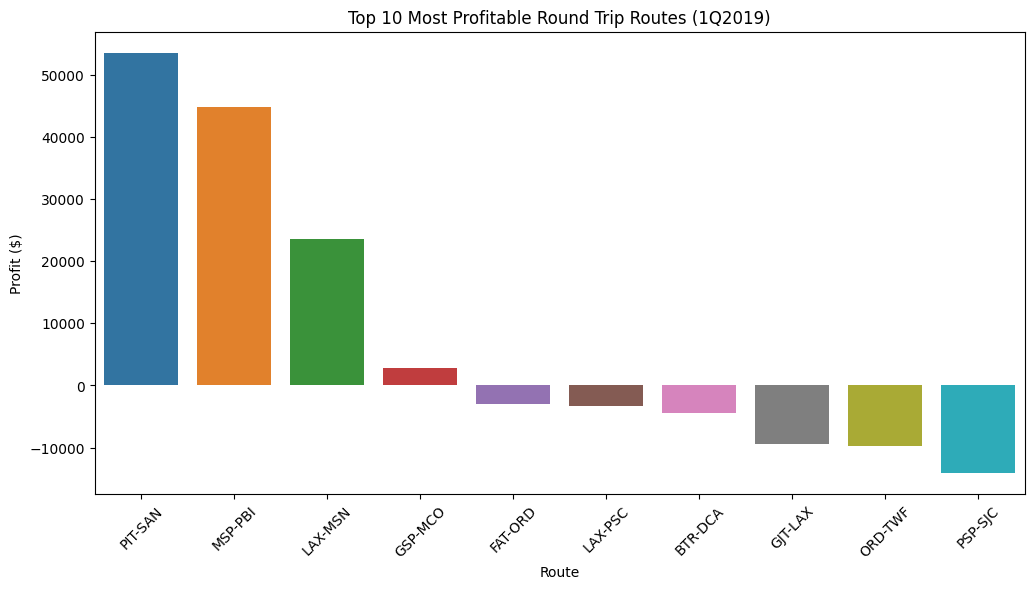

In [20]:
# Example: Bar chart for Top 10 Most Profitable Routes
plt.figure(figsize=(12, 6))
sns.barplot(x='ROUTE', y='PROFIT', data=top_10_profitable)
plt.title('Top 10 Most Profitable Round Trip Routes (1Q2019)')
plt.xlabel('Route')
plt.ylabel('Profit ($)')
plt.xticks(rotation=45)
plt.show()